In [9]:
import sys
import torch
sys.path.append('..')
from models.encoder import TransformerEncoder
from models.mlp import MLP 
from models.vgg16 import VGG16
import timm
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
import models.sapflow_predict as sfp_models
from pathlib import Path
import models.sapflow_predict as sfp_models
import models.soil_moisture_predict as smp_models
import dataset.sapflow_predict as sfp_datasets
import dataset.soil_moisture_predict as smp_datasets
from torch.utils.data import DataLoader, Dataset

In [2]:
model = sfp_models.RgbVgg16Model()

In [4]:
src_dir = Path('../')
rgb_images_dir = src_dir / 'data' / 'rgb_images'
segment_images_dir = src_dir / 'data' / 'segment_rgb_images'
# infrared_image_dir = src_dir / 'data' / 'thermal_data_processed'
temp_moisture_file_path = src_dir / 'data' / 'series_data' / 'T_moisture_data.csv'
soil_moisture_file_path = src_dir / 'data' / 'labels' / 'soil_water_content.CSV'
sapflow_rgb_images_dir = src_dir / 'data' / 'sapflow_predict_data' / 'rgb_images'
sapflow_dir = src_dir / 'data' / 'sapflow_predict_data' / 'sapflow'


In [8]:
dataset = sfp_datasets.RgbTmDataset(
    rgb_images_dir=sapflow_rgb_images_dir,
    tm_file_path=temp_moisture_file_path,
    sapflow_dir=sapflow_dir,
    transform=model.get_image_transform(is_training=False)
)

In [20]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

In [12]:
for data in dataset:
    image, temp_moistures, label = data
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


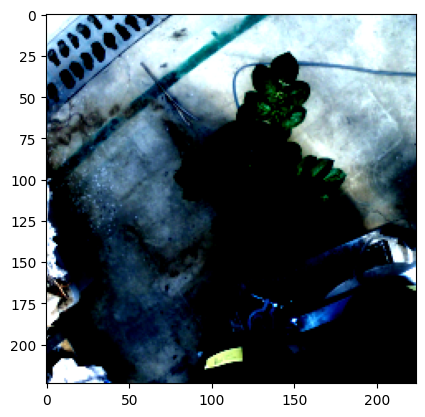

In [13]:
plt.imshow(image.permute(1, 2, 0))

In [15]:
print(image.shape)
print(temp_moistures.shape)

torch.Size([3, 224, 224])
torch.Size([144, 2])


In [21]:
for data in dataloader:
    image_loader, temp_moistures_loader, label_loader = data
    break

In [22]:
print(image_loader.shape)
print(temp_moistures_loader.shape)
print(label_loader.shape)

torch.Size([32, 3, 224, 224])
torch.Size([32, 144, 2])
torch.Size([32, 1])


In [23]:
output = model(image_loader)

In [19]:
output = model(image)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (4096x1 and 4096x512)

In [2]:
weights_path = '../model_weights/vgg16.bin'
vgg16 = VGG16(
    weights_path=weights_path,
    num_classes=512,
    finetune=True
)

In [37]:
data_config = timm.data.resolve_model_data_config(vgg16.model)
train_transform = timm.data.create_transform(**data_config, is_training=True)
val_transform = timm.data.create_transform(**data_config, is_training=False)
my_transform = transforms.Compose([
                transforms.Resize(256),
                # transforms.RandomCrop(224),
                # transforms.RandomHorizontalFlip(),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ])

In [38]:
input_image = Image.open('../data/rgb_images/10-30/1.JPG')
train_output_image = train_transform(input_image)
val_output_image = val_transform(input_image)
my_output_image = my_transform(input_image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


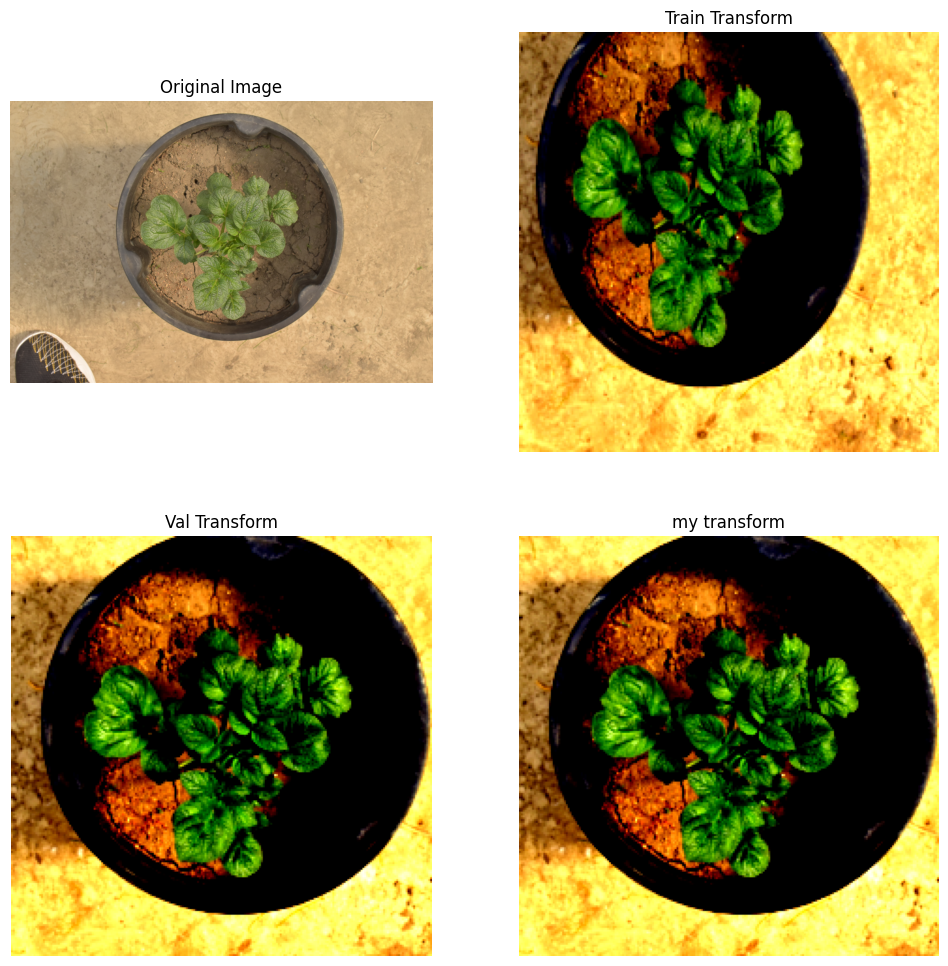

In [39]:
fig, axes = plt.subplots(2, 2, figsize=(12,12))
axes[0,0].imshow(input_image)
axes[0,0].set_title('Original Image')
axes[0,0].axis('off')
axes[0,1].imshow(train_output_image.permute(1,2,0))
axes[0,1].set_title('Train Transform')
axes[0,1].axis('off')
axes[1,0].imshow(val_output_image.permute(1,2,0))
axes[1,0].set_title('Val Transform')
axes[1,0].axis('off')
axes[1,1].imshow(my_output_image.permute(1,2,0))
axes[1,1].set_title('my transform')
axes[1,1].axis('off')
plt.show()

In [8]:
print(train_transform)
print(val_transform)

Compose(
    RandomResizedCropAndInterpolation(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    ColorJitter(brightness=(0.6, 1.4), contrast=(0.6, 1.4), saturation=(0.6, 1.4), hue=None)
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)


In [8]:
encoder = TransformerEncoder(
    input_dim = 2,
    d_model = 6,
    nhead = 2,
    nhid = 8,
    nlayers = 2,
    dropout = 0.1
)

In [12]:
mlp = MLP(
    input_size = 2,
    hidden_size = 32,
    num_classes = 16
)

In [15]:
inputs = torch.Tensor([[
    [1,2],
    [3,4]
]])
output = encoder(inputs)


In [5]:
output.shape

torch.Size([2, 6])

In [16]:
print(inputs)
output = mlp(inputs)
print(output.shape)

tensor([[[1., 2.],
         [3., 4.]]])
torch.Size([1, 2, 16])


In [19]:
output.flatten(1)

tensor([[ 0.1576,  0.0602, -0.3293,  0.1471,  0.1415,  0.2736,  0.0292,  0.2875,
         -0.1214,  0.0124,  0.0691,  0.0091, -0.3747, -0.0110,  0.0917,  0.1980,
          0.1346,  0.2845, -0.6309,  0.2916,  0.5019,  0.2796, -0.0506,  0.4298,
         -0.3722, -0.0907, -0.0172,  0.1235, -0.6613,  0.2546,  0.2122,  0.2904]],
       grad_fn=<ViewBackward0>)

In [20]:
output.shape

torch.Size([1, 2, 16])